In [1]:
import numpy as np
import cv2
import os
import re
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Dataset loaded
180 224 (224, 224) 70 180 70


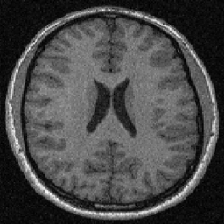

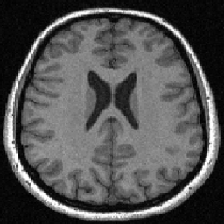

In [2]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset/train/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(1)
    return np.array(images_train), np.array(images_test), np.array(labels_train), np.array(labels_test)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")
imgs_train, imgs_test, labels_train, labels_test = X_train_ml, X_test_ml, y_train_ml, y_test_ml
#print(X_train_ml, X_test_ml, y_train_ml, y_test_ml)
print(len(X_train_ml),len(X_train_ml[0]), X_train_ml[0].shape,len(X_test_ml), len(y_train_ml), len(y_test_ml))
from google.colab.patches import cv2_imshow
cv2_imshow(imgs_train[5])
cv2_imshow(imgs_test[5])

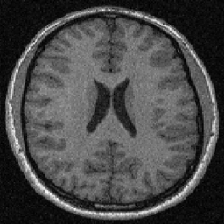

(180, 55)

In [3]:
from skimage.feature import graycomatrix, graycoprops
imgs = imgs_train.astype(np.int32)
labels = labels_train.astype(np.int32)
cv2_imshow(imgs[5])
# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

glcm_df.shape

In [4]:
from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape

(180, 5409)

In [5]:
from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
#combined_df = glcm_df
#combined_df = lbp_df
#combined_df = hog_df
print(combined_df)
# Assuming 'label' is the target variable

X_train_df = combined_df.drop(columns=['label'])
y_train_df = combined_df['label']

#X = combined_df.drop(combined_df.index[-1])
#y = combined_df.iloc[-1]

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_train = scaler_combined.fit_transform(X_train_df.values)

        hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0    0.210511  0.173358  0.116965  0.192699  0.210511  0.109547  0.166457   
1    0.214378  0.125934  0.099652  0.130322  0.216730  0.092761  0.216730   
2    0.223118  0.090039  0.138010  0.108327  0.223118  0.112703  0.154845   
3    0.228395  0.074987  0.208732  0.117971  0.228395  0.109409  0.187149   
4    0.224108  0.165916  0.224108  0.119677  0.224108  0.116038  0.149503   
..        ...       ...       ...       ...       ...       ...       ...   
175  0.164683  0.085056  0.099935  0.134446  0.216550  0.128374  0.203630   
176  0.211498  0.189888  0.187809  0.136749  0.212176  0.136570  0.180724   
177  0.211989  0.121957  0.172168  0.120081  0.200257  0.133154  0.112861   
178  0.217702  0.075560  0.105296  0.103920  0.217702  0.178592  0.156234   
179  0.218507  0.171930  0.176969  0.106933  0.218507  0.117775  0.125054   

        hog_7     hog_8     hog_9  ...  energy_0  energy_0.5235987755982988

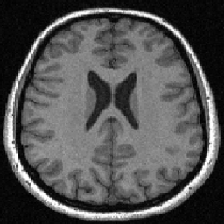

       hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0   0.214272  0.123859  0.136935  0.182572  0.214272  0.112053  0.159911   
1   0.224551  0.127218  0.183236  0.164603  0.224551  0.099683  0.195822   
2   0.215333  0.085689  0.187427  0.129934  0.215333  0.162799  0.137545   
3   0.212166  0.124422  0.188900  0.190917  0.219322  0.119070  0.149420   
4   0.229317  0.137703  0.169647  0.112026  0.229317  0.146841  0.176867   
..       ...       ...       ...       ...       ...       ...       ...   
65  0.218464  0.152240  0.155960  0.107407  0.218464  0.107451  0.195002   
66  0.175889  0.137136  0.132213  0.096616  0.191682  0.145683  0.144870   
67  0.218960  0.187973  0.191527  0.134418  0.218960  0.133327  0.123432   
68  0.219585  0.095003  0.170192  0.104138  0.215739  0.140391  0.153924   
69  0.216871  0.121479  0.166001  0.191253  0.215025  0.100441  0.169289   

       hog_7     hog_8     hog_9  ...  energy_0  energy_0.5235987755982988  \
0   0.191

In [6]:
from skimage.feature import graycomatrix, graycoprops
imgs = imgs_test.astype(np.int32)
labels = labels_test.astype(np.int32)
cv2_imshow(imgs[5])

# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

glcm_df.shape

from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape

from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
#combined_df = glcm_df
#combined_df = lbp_df
#combined_df = hog_df
print(combined_df)
# Assuming 'label' is the target variable

X_test_df = combined_df.drop(columns=['label'])
y_test_df = combined_df['label']

#X = combined_df.drop(combined_df.index[-1])
#y = combined_df.iloc[-1]

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_test = scaler_combined.fit_transform(X_test_df.values)

In [7]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.svm import SVC
num_selected_features = 180

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train_df)
y_test_ml = label_encoder.fit_transform(y_test_df)

print(X_scaled_train.shape, X_scaled_test.shape, y_train_ml.shape, y_test_ml.shape)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_scaled_train, X_scaled_test, y_train_ml, y_test_ml

pca = PCA(n_components=num_selected_features)
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
print(X_train_pca.shape, X_test_pca.shape)
# Function to train and evaluate a classifier
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
      model = classifier
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      y_prob = model.predict_proba(X_test)
      auc_roc = roc_auc_score(y_test, y_prob[:, 1])
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test, y_pred)
      specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
      print(f"\nPerfomance Metrics:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

# Train and evaluate classifiers after PCA
# Logistic Regression
print("\nLogistic Regression:")
train_and_evaluate_classifier(LogisticRegression(max_iter=100), X_train_pca,  y_train_pca, X_test_pca, y_test_pca)

# Decision Tree
print("\nDecision Tree:")
train_and_evaluate_classifier(DecisionTreeClassifier(random_state=104), X_train_pca, y_train_pca, X_test_pca, y_test_pca)


# SVC
print("\nSVC:")
train_and_evaluate_classifier(SVC(kernel='linear', probability=True,random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Random Forest
print("\nRandom Forest:")
train_and_evaluate_classifier(RandomForestClassifier(n_estimators=1000, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Gradient Boosted Trees
print("\nGradient Boosted Trees:")
train_and_evaluate_classifier(GradientBoostingClassifier(n_estimators=100, random_state=59), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Extra Trees
print("\nExtra Trees:")
train_and_evaluate_classifier(ExtraTreesClassifier(n_estimators=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# AdaBoost
print("\nAdaBoost:")
train_and_evaluate_classifier(AdaBoostClassifier(n_estimators=50, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# HistGradientBoosting
print("\nHistGradientBoosting:")
train_and_evaluate_classifier(HistGradientBoostingClassifier(max_iter=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

(180, 5664) (70, 5664) (180,) (70,)
(180, 180) (70, 180)

Logistic Regression:

Perfomance Metrics:
Accuracy: 0.86
Precision: 0.86
Sensitivity (Recall): 0.89
Specificity: 0.83
F1 Score: 0.86
AUC-ROC Score: 0.95
Confusion matrix:
 [[29  6]
 [ 4 31]]

Decision Tree:

Perfomance Metrics:
Accuracy: 0.71
Precision: 0.73
Sensitivity (Recall): 0.60
Specificity: 0.83
F1 Score: 0.71
AUC-ROC Score: 0.71
Confusion matrix:
 [[29  6]
 [14 21]]

SVC:

Perfomance Metrics:
Accuracy: 0.86
Precision: 0.86
Sensitivity (Recall): 0.89
Specificity: 0.83
F1 Score: 0.86
AUC-ROC Score: 0.95
Confusion matrix:
 [[29  6]
 [ 4 31]]

Random Forest:

Perfomance Metrics:
Accuracy: 0.83
Precision: 0.83
Sensitivity (Recall): 0.77
Specificity: 0.89
F1 Score: 0.83
AUC-ROC Score: 0.92
Confusion matrix:
 [[31  4]
 [ 8 27]]

Gradient Boosted Trees:

Perfomance Metrics:
Accuracy: 0.80
Precision: 0.80
Sensitivity (Recall): 0.74
Specificity: 0.86
F1 Score: 0.80
AUC-ROC Score: 0.86
Confusion matrix:
 [[30  5]
 [ 9 26]]

Extra T

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd

num_selected_features = 512

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train_df)
y_test_ml = label_encoder.fit_transform(y_test_df)

print(X_scaled_train.shape, X_scaled_test.shape, y_train_ml.shape, y_test_ml.shape)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = X_scaled_train, X_scaled_test, y_train_ml, y_test_ml


  # Assuming X contains your feature matrix of shape (n_samples, n_features)

# Create SelectKBest with f_classif scoring function
selector = SelectKBest(score_func=f_classif, k=512)

# Fit selector to your data and transform X to select the top 512 features
X_train_pca = selector.fit_transform(X_train_pca, y_train_pca)
X_test_pca = selector.fit_transform(X_test_pca, y_test_pca)
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
X_train_pca= pd.DataFrame(X_train_pca, columns=selected_feature_indices)
X_test_pca = pd.DataFrame(X_test_pca, columns=selected_feature_indices)

# Function to train and evaluate a classifier
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
      model = classifier
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      y_prob = model.predict_proba(X_test)
      auc_roc = roc_auc_score(y_test, y_prob[:, 1])
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test, y_pred)
      specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
      print(f"\nPerfomance Metrics:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

# Train and evaluate classifiers after PCA
# Logistic Regression
print("\nLogistic Regression:")
train_and_evaluate_classifier(LogisticRegression(max_iter=100), X_train_pca,  y_train_pca, X_test_pca, y_test_pca)

# Decision Tree
print("\nDecision Tree:")
train_and_evaluate_classifier(DecisionTreeClassifier(random_state=104), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# SVC
print("\nSVC:")
train_and_evaluate_classifier(SVC(kernel='linear', probability=True,random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Random Forest
print("\nRandom Forest:")
train_and_evaluate_classifier(RandomForestClassifier(n_estimators=1000, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Gradient Boosted Trees
print("\nGradient Boosted Trees:")
train_and_evaluate_classifier(GradientBoostingClassifier(n_estimators=100, random_state=59), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Extra Trees
print("\nExtra Trees:")
train_and_evaluate_classifier(ExtraTreesClassifier(n_estimators=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# AdaBoost
print("\nAdaBoost:")
train_and_evaluate_classifier(AdaBoostClassifier(n_estimators=50, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# HistGradientBoosting
print("\nHistGradientBoosting:")
train_and_evaluate_classifier(HistGradientBoostingClassifier(max_iter=100, random_state=42), X_train_pca, y_train_pca, X_test_pca, y_test_pca)

(180, 5664) (70, 5664) (180,) (70,)

Logistic Regression:

Perfomance Metrics:
Accuracy: 0.60
Precision: 0.61
Sensitivity (Recall): 0.71
Specificity: 0.49
F1 Score: 0.59
AUC-ROC Score: 0.70
Confusion matrix:
 [[17 18]
 [10 25]]

Decision Tree:

Perfomance Metrics:
Accuracy: 0.64
Precision: 0.67
Sensitivity (Recall): 0.83
Specificity: 0.46
F1 Score: 0.63
AUC-ROC Score: 0.64
Confusion matrix:
 [[16 19]
 [ 6 29]]

SVC:

Perfomance Metrics:
Accuracy: 0.61
Precision: 0.62
Sensitivity (Recall): 0.71
Specificity: 0.51
F1 Score: 0.61
AUC-ROC Score: 0.74
Confusion matrix:
 [[18 17]
 [10 25]]

Random Forest:

Perfomance Metrics:
Accuracy: 0.41
Precision: 0.40
Sensitivity (Recall): 0.57
Specificity: 0.26
F1 Score: 0.40
AUC-ROC Score: 0.41
Confusion matrix:
 [[ 9 26]
 [15 20]]

Gradient Boosted Trees:

Perfomance Metrics:
Accuracy: 0.63
Precision: 0.63
Sensitivity (Recall): 0.63
Specificity: 0.63
F1 Score: 0.63
AUC-ROC Score: 0.72
Confusion matrix:
 [[22 13]
 [13 22]]

Extra Trees:

Perfomance Met

(180, 5664) (70, 5664) (180,) (70,)
(180, 512) Int64Index([  75,   76,   77,   78,   79,   80,   81,   82,   83,   84,
            ...
            4170, 4473, 4521, 4652, 4685, 4902, 5288, 5467, 5621, 5629],
           dtype='int64', length=512)

Metrics for LogisticRegression:
Accuracy: 0.86
Precision: 0.86
Sensitivity (Recall): 0.86
Specificity: 0.86
F1 Score: 0.86
AUC-ROC Score: 0.96
Confusion matrix:
 [[30  5]
 [ 5 30]]


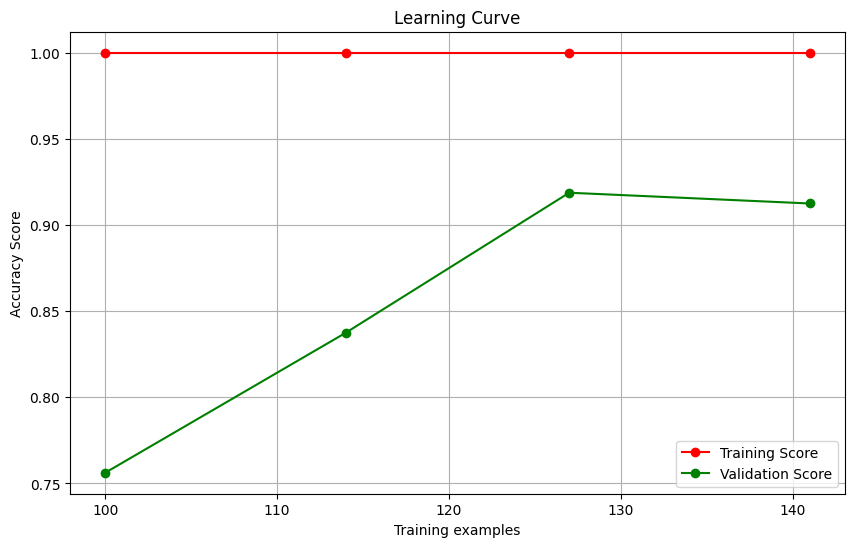


Metrics for DecisionTreeClassifier:
Accuracy: 0.61
Precision: 0.61
Sensitivity (Recall): 0.63
Specificity: 0.60
F1 Score: 0.61
AUC-ROC Score: 0.61
Confusion matrix:
 [[21 14]
 [13 22]]

Metrics for SVC:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.86
Specificity: 0.89
F1 Score: 0.87
AUC-ROC Score: 0.94
Confusion matrix:
 [[31  4]
 [ 5 30]]


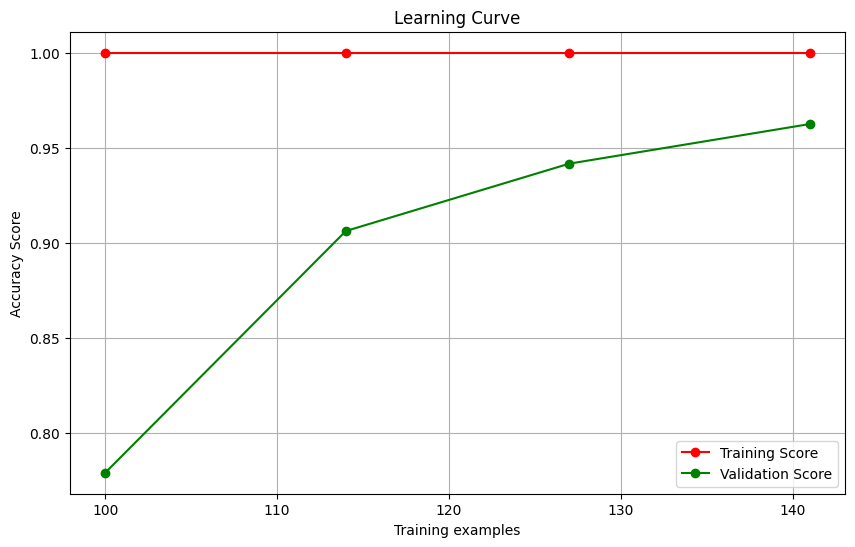


Metrics for HistGradientBoostingClassifier:
Accuracy: 0.80
Precision: 0.81
Sensitivity (Recall): 0.89
Specificity: 0.71
F1 Score: 0.80
AUC-ROC Score: 0.92
Confusion matrix:
 [[25 10]
 [ 4 31]]


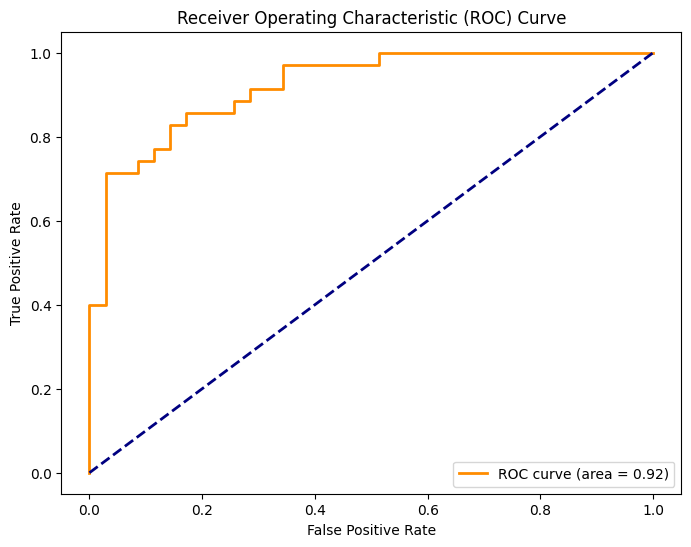

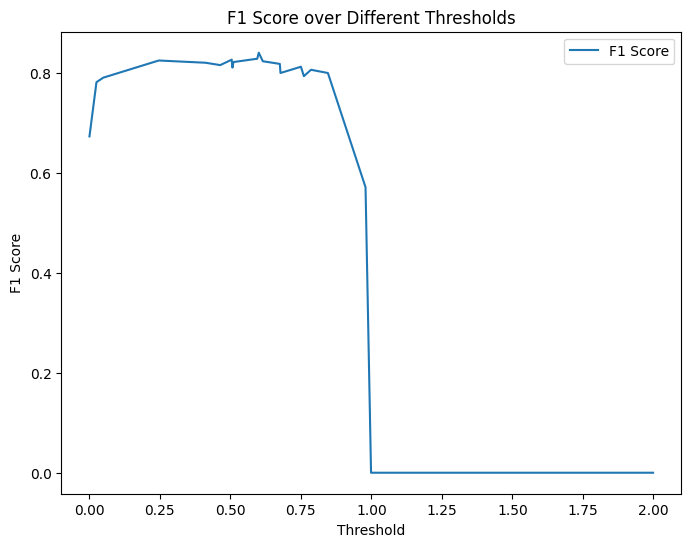

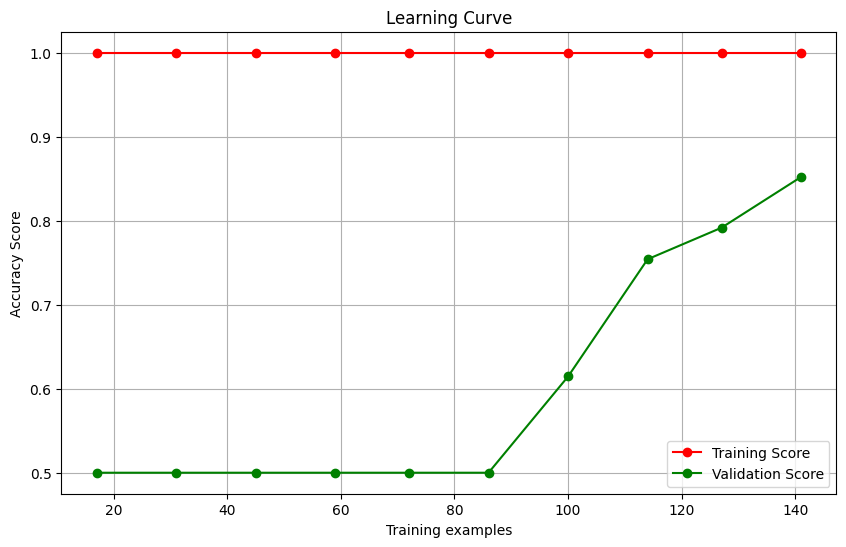


Metrics for RandomForestClassifier:
Accuracy: 0.86
Precision: 0.86
Sensitivity (Recall): 0.86
Specificity: 0.86
F1 Score: 0.86
AUC-ROC Score: 0.96
Confusion matrix:
 [[30  5]
 [ 5 30]]


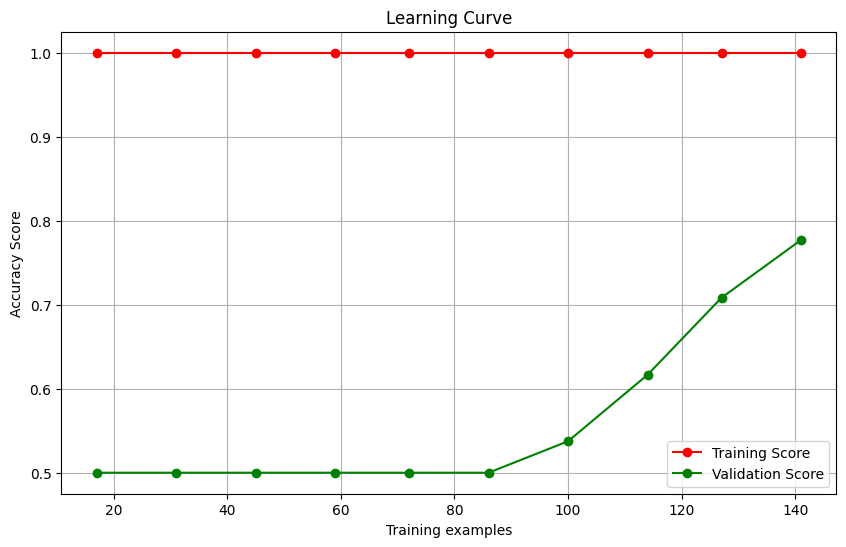


Metrics for GradientBoostingClassifier:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.86
Specificity: 0.89
F1 Score: 0.87
AUC-ROC Score: 0.94
Confusion matrix:
 [[31  4]
 [ 5 30]]


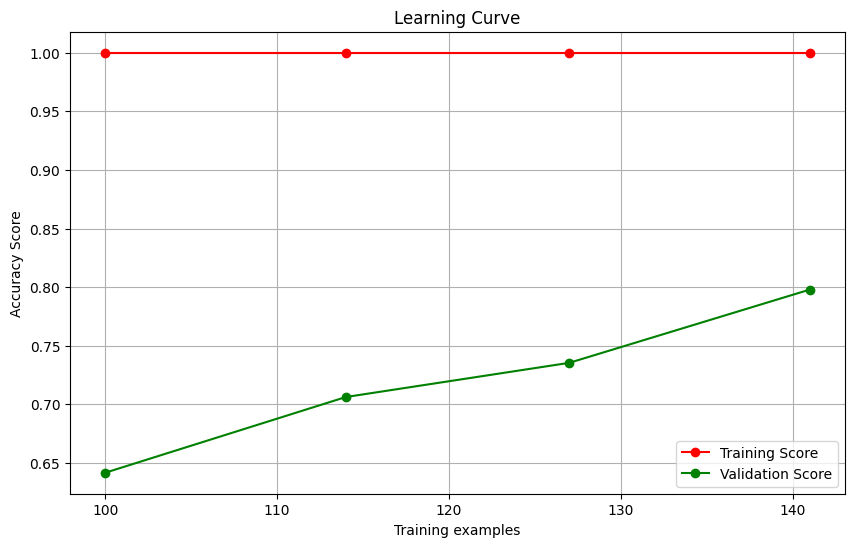


Metrics for ExtraTreesClassifier:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.91
Specificity: 0.83
F1 Score: 0.87
AUC-ROC Score: 0.94
Confusion matrix:
 [[29  6]
 [ 3 32]]


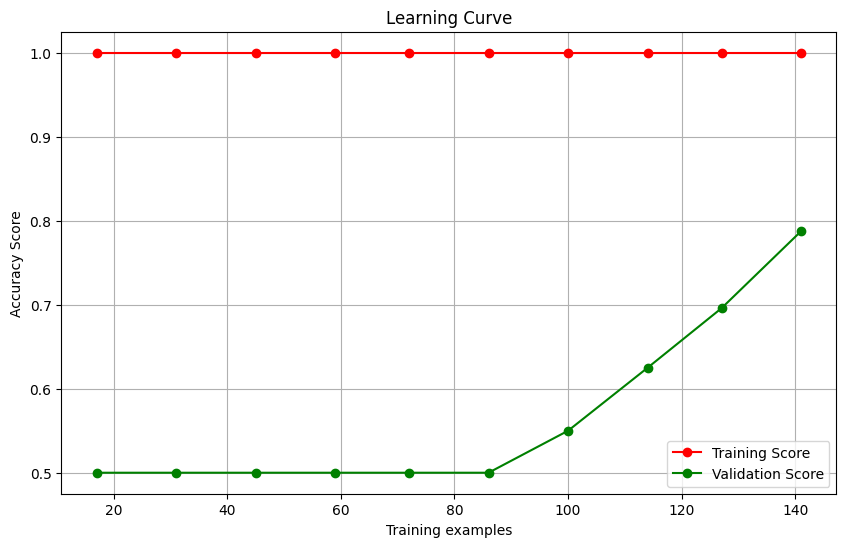


Metrics for AdaBoostClassifier:
Accuracy: 0.84
Precision: 0.85
Sensitivity (Recall): 0.80
Specificity: 0.89
F1 Score: 0.84
AUC-ROC Score: 0.92
Confusion matrix:
 [[31  4]
 [ 7 28]]


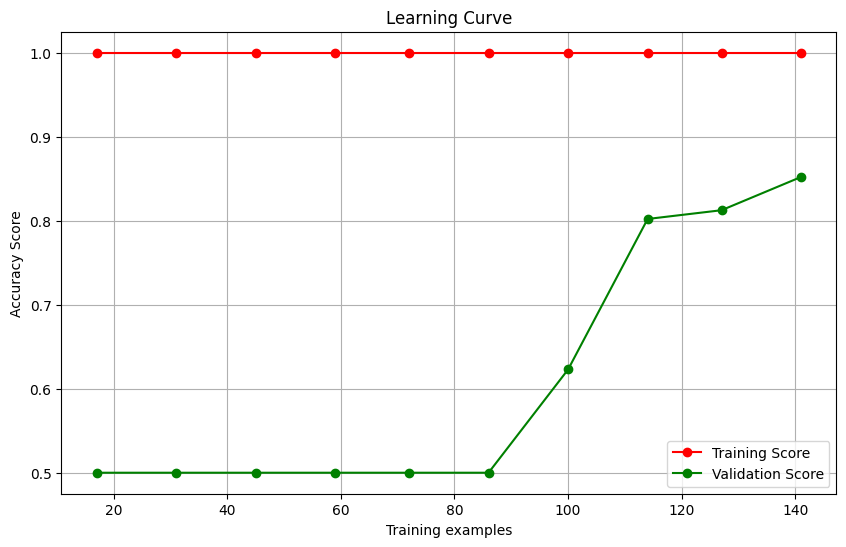


Metrics for XGBClassifier:
Accuracy: 0.87
Precision: 0.87
Sensitivity (Recall): 0.91
Specificity: 0.83
F1 Score: 0.87
AUC-ROC Score: 0.95
Confusion matrix:
 [[29  6]
 [ 3 32]]


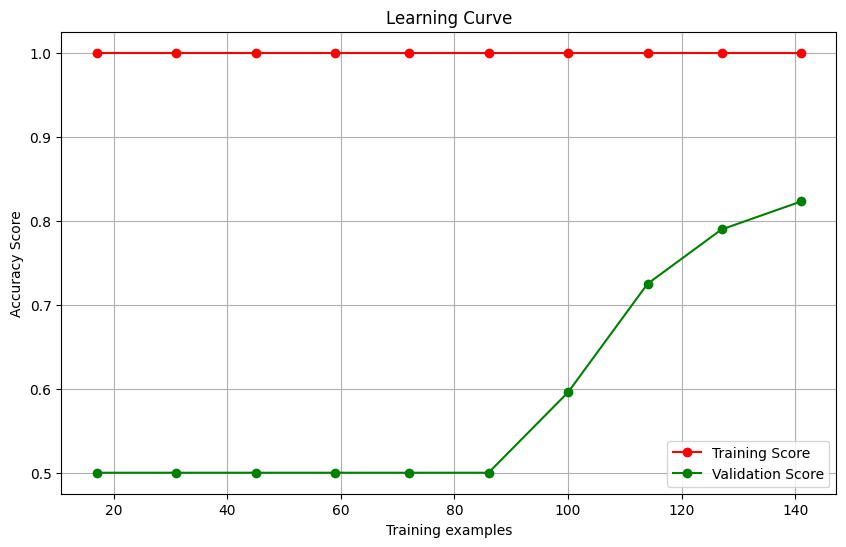

In [9]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train_df)
y_test_ml = label_encoder.fit_transform(y_test_df)

print(X_scaled_train.shape, X_scaled_test.shape, y_train_ml.shape, y_test_ml.shape)

X_train_ml_rfe, X_test_ml_rfe, y_train_ml_rfe, y_test_ml_rfe = X_scaled_train, X_scaled_test, y_train_ml, y_test_ml

num_selected_features = 512

def train_evaluate_rfe(classifier, X_train_ml_rfe, y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_roc=False, plot_f1=False, plot_corr=False, plot_learning_curve = False):

      # Train the model using the selected features
      model = classifier
      model.fit(X_train_ml_rfe, y_train_ml_rfe)

      # Evaluate the model on the test set
      X_test_rfe = X_test_ml_rfe[:, rfe.support_]
      y_pred = model.predict(X_test_rfe)

      # Predict probabilities for each class on the test set
      y_prob = model.predict_proba(X_test_rfe)
       # Calculate AUC-ROC score for the positive class
      fpr, tpr, thresholds = roc_curve(y_test_ml_rfe, y_prob[:, 1])
      auc_roc = auc(fpr, tpr)
      # Calculate AUC-ROC score for the positive class
      auc_roc_score = roc_auc_score(y_test_ml_rfe, y_prob[:, 1])

      # Print metrics
      accuracy = accuracy_score(y_test_ml_rfe, y_pred)
      precision = precision_score(y_test_ml_rfe, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test_ml_rfe, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test_ml_rfe, y_pred)
      # specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

      # Handle the case when there are no true negatives
      if conf_matrix[0, 0] + conf_matrix[0, 1] != 0:
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
      else:
        specificity = 0.0
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

      print(f"\nMetrics for {type(classifier).__name__}:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc_score:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

      if plot_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_roc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

      # Plot F1 score over different thresholds
      if plot_f1:
        plt.figure(figsize=(8, 6))
        f1_scores = [f1_score(y_test_ml_rfe, y_prob[:, 1] > threshold) for threshold in thresholds]
        plt.plot(thresholds, f1_scores, label='F1 Score')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score over Different Thresholds')
        plt.legend()
        plt.show()

      # Print correlation matrix
      if plot_corr:
        corr_matrix = X_train_ml_rfe.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Selected Features')
        plt.show()

      if plot_learning_curve:
        train_sizes, train_scores, validation_scores = learning_curve(classifier, X_train_ml_rfe, y_train_ml_rfe, cv=80, scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 10))
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training Score")
        plt.plot(train_sizes, np.mean(validation_scores, axis=1), 'o-', color="g", label="Validation Score")

        plt.xlabel("Training examples")
        plt.ylabel("Accuracy Score")
        plt.title("Learning Curve")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

# Create the RFE model with Logistic Regression as the estimator
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
rfe = RFE(estimator, n_features_to_select=num_selected_features,importance_getter='coef_')

# Fit the RFE model to the training data
X = pd.concat([pd.DataFrame(X_train_ml_rfe),pd.DataFrame(X_test_ml_rfe)],axis=0)
X_train_rfe = rfe.fit_transform(X_train_ml_rfe, y_train_ml_rfe)

# Get the selected feature names
selected_feature_names = X.columns[rfe.support_]

# Convert X_train_rfe to a DataFrame with column names
X_train_ml_rfe = pd.DataFrame(X_train_rfe, columns=selected_feature_names)
print(X_train_ml_rfe.shape,X_train_ml_rfe.columns)

#Logistic Regression
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, plot_learning_curve=True)

# Decision Tree
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = DecisionTreeClassifier(random_state=104)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=104)

# Define an SVM classifier
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = SVC(kernel='linear',probability=True, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_learning_curve=True)

# HistGradientBoosting Classifier
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
train_evaluate_rfe(classifier , X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features ,plot_roc=True, plot_f1=True, plot_corr=False, plot_learning_curve=True)

# Random Forest
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = RandomForestClassifier(n_estimators=100, random_state=29)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=29, plot_learning_curve=True)

# Gradient Boosted Trees
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = GradientBoostingClassifier(n_estimators=100, random_state=59)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=59, plot_learning_curve=True)

# Extra Trees Classifier
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = ExtraTreesClassifier(n_estimators=100, random_state=20)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features,random_state=20, plot_learning_curve=True)

# AdaBoost Classifier
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, plot_learning_curve=True)

# XGBoost Classifier
estimator = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
classifier = XGBClassifier(n_estimators=100, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_rfe,  y_train_ml_rfe, X_test_ml_rfe, y_test_ml_rfe, num_selected_features, random_state=42, plot_learning_curve=True)
